# Connect DRN items to SFR reaches

In [1]:
from WS_Mdl.utils import Sign, Pre_Sign
import WS_Mdl.utils as U
import WS_Mdl.utils_imod as UIM
import WS_Mdl.geo as G
import os
from os import listdir as LD, makedirs as MDs
from os.path import join as PJ, basename as PBN, dirname as PDN, exists as PE
import shutil as sh
import re
from datetime import datetime as DT
from typing import Optional, Dict
import rasterio
from rasterio.transform import from_bounds
import imod
import numpy as np
import xarray as xr
from pathlib import Path
import pandas as pd

pd.set_option('display.max_rows', 30)  # show up to 30 rows
import geopandas as gpd
from shapely.geometry import Point as Pt
from concurrent.futures import ProcessPoolExecutor as PPE
import zipfile as ZF
import xml.etree.ElementTree as ET
import sys
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
import DRN_SFR_match
from DRN_SFR_match import match_cells_to_SFR
import write_MVR
from write_MVR import w_MVR

In [44]:
import importlib as IL

IL.reload(U)
IL.reload(G)
IL.reload(DRN_SFR_match)
match_cells_to_SFR = DRN_SFR_match.match_cells_to_SFR
IL.reload(write_MVR)
from write_MVR import w_MVR

# 1. Options.

In [3]:
MdlN, MdlN_B = 'NBr29', 'NBr28'

In [4]:
d_Pa = U.get_MdlN_Pa(MdlN)
Pa_SFR = PJ(d_Pa['Pa_Mdl'], f'In/SFR/{MdlN}/{MdlN}.SFR6')
MDs(PDN(Pa_SFR), exist_ok=True)  # Make dir for SFR file.

In [5]:
Xmin, Ymin, Xmax, Ymax, cellsize, N_R, N_C = U.Mdl_Dmns_from_INI(d_Pa['INI'])

🟢 - INI file C:/OD/WS_Mdl\models/NBr\code/Mdl_Prep/Mdl_Prep_NBr29.ini read successfully. Dictionary created with 22 keys.
🟢 - model dimensions extracted from C:/OD/WS_Mdl\models/NBr\code/Mdl_Prep/Mdl_Prep_NBr29.ini.


In [6]:
# Pa_Ctmt = r'C:\OD\WS_Mdl\models\NBr\PoP\common\Pgn\Chaamse_beek\catchment_chaamsebeek_ulvenhout.shp'
Pa_SFR_Atv = r'C:\OD\WS_Mdl\models\NBr\In\SFR\_other\RIV_Bot_active.IDF'

In [7]:
Pa_DRN = r'C:\OD\WS_Mdl\models\NBr\Sim\NBr29\GWF_1\MODELINPUT\DRN6\DRN_T1.ARR'

# 2. Load Stuff

## 2.0. Read PRJ

In [8]:
U.set_verbose(False)

In [9]:
DF_full = UIM.PRJ_to_DF(MdlN)
DF_full

,package,parameter,MdlN,time,active,is_constant,layer,factor,addition,constant,suffix,path
(CAP)_boundary,CAP,boundary,NBr1,NaN,True,2,1,1.0,0.0,-9999.0,.idf,C:/OD/WS_Mdl\models\NBr\In\BND\BND_L1_NBr1.IDF
(CAP)_landuse,CAP,landuse,NBr1,NaN,True,2,1,1.0,0.0,100000000000000000000.0,.idf,C:/OD/WS_Mdl\models\NBr\In\CAP\LGN\LGN_NBr1.idf
(CAP)_rootzone_thickness,CAP,rootzone_thickness,NBr1,NaN,True,2,1,1.0,0.0,100000000000000000000.0,.idf,C:/OD/WS_Mdl\models\NBr\In\CAP\RZN\RZN_NBr1.idf
(CAP)_soil_physical_unit,CAP,soil_physical_unit,NBr1,NaN,True,2,1,1.0,0.0,100000000000000000000.0,.idf,C:/OD/WS_Mdl\models\NBr\In\CAP\SFU\SFU_NBr1.idf
(CAP)_meteo_station_number,CAP,meteo_station_number,NBr1,NaN,True,2,1,1.0,0.0,-9999.0,.idf,C:/OD/WS_Mdl\models\NBr\In\BND\BND_L1_NBr1.IDF
...,...,...,...,...,...,...,...,...,...,...,...,...
(CHD)_head_Sys17_2018-12-14 00:00:00,CHD,head,NBr5,2018-12-14 00:00:00,True,2,33,1.0,0.0,-999.99,.idf,C:/OD/WS_Mdl\models\NBr\In\CHD\NBr5\head_20181...
(CHD)_head_Sys18_2018-12-14 00:00:00,CHD,head,NBr5,2018-12-14 00:00:00,True,2,35,1.0,0.0,-999.99,.idf,C:/OD/WS_Mdl\models\NBr\In\CHD\NBr5\head_20181...
(CHD)_head_Sys19_2018-12-14 00:00:00,CHD,head,NBr5,2018-12-14 00:00:00,True,2,37,1.0,0.0,-999.99,.idf,C:/OD/WS_Mdl\models\NBr\In\CHD\NBr5\head_20181...
PERIODS,-,-,-,-,Failed to read package,-,-,-,-,-,-,-


## 2.1. SFR active

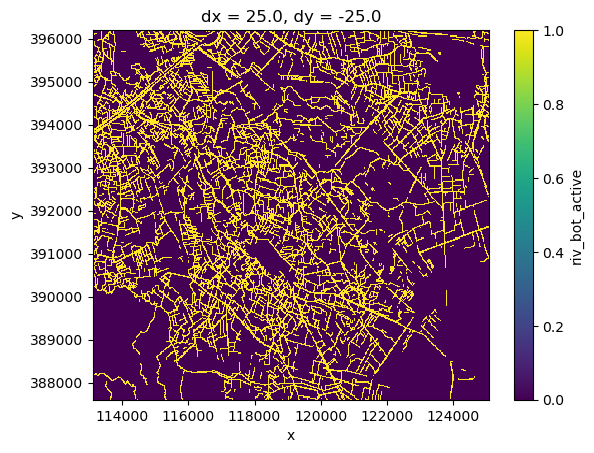

In [10]:
A_SFR_Atv = imod.formats.idf.open(Pa_SFR_Atv).sel(
    x=slice(Xmin, Xmax), y=slice(Ymax, Ymin)
)  # 666 To be replaced with proper active SFR array from SFR file.
A_SFR_Atv.plot()

## 2.2. DRNs

In [11]:
DF_DRN = DF_full.loc[DF_full['package'] == 'DRN']
DF_DRN

,package,parameter,MdlN,time,active,is_constant,layer,factor,addition,constant,suffix,path
(DRN)_conductance_Sys1_steady-state,DRN,conductance,NBr1,steady-state,True,2,1,1.0,0.0,-999.99,.idf,C:/OD/WS_Mdl\models\NBr\In\DRN\DRN_Cond_buis_N...
(DRN)_conductance_Sys2_steady-state,DRN,conductance,NBr1,steady-state,True,2,1,1.0,0.0,-999.99,.idf,C:/OD/WS_Mdl\models\NBr\In\DRN\DRN_Cond_MV_25M...
(DRN)_conductance_Sys3_steady-state,DRN,conductance,NBr1,steady-state,True,2,1,1.0,0.0,-999.99,.idf,C:/OD/WS_Mdl\models\NBr\In\DRN\DRN_Cond_ONTWAT...
(DRN)_conductance_Sys1_2010-01-01 00:00:00,DRN,conductance,NBr1,2010-01-01 00:00:00,True,2,1,1.0,0.0,-999.99,.idf,C:/OD/WS_Mdl\models\NBr\In\DRN\DRN_Cond_buis_N...
(DRN)_conductance_Sys2_2010-01-01 00:00:00,DRN,conductance,NBr1,2010-01-01 00:00:00,True,2,1,1.0,0.0,-999.99,.idf,C:/OD/WS_Mdl\models\NBr\In\DRN\DRN_Cond_MV_25M...
(DRN)_conductance_Sys3_2010-01-01 00:00:00,DRN,conductance,NBr1,2010-01-01 00:00:00,True,2,1,1.0,0.0,-999.99,.idf,C:/OD/WS_Mdl\models\NBr\In\DRN\DRN_Cond_ONTWAT...
(DRN)_elevation_Sys1_steady-state,DRN,elevation,NBr1,steady-state,True,2,1,1.0,0.0,-999.99,.idf,C:/OD/WS_Mdl\models\NBr\In\DRN\DRN_Elv_buis_NB...
(DRN)_elevation_Sys2_steady-state,DRN,elevation,NBr1,steady-state,True,2,1,1.0,0.0,-999.99,.idf,C:/OD/WS_Mdl\models\NBr\In\DRN\DRN_Elv_MV_25M_...
(DRN)_elevation_Sys3_steady-state,DRN,elevation,NBr1,steady-state,True,2,1,1.0,0.0,-999.99,.idf,C:/OD/WS_Mdl\models\NBr\In\DRN\DRN_Elv_BELGIE_...
(DRN)_elevation_Sys1_2010-01-01 00:00:00,DRN,elevation,NBr1,2010-01-01 00:00:00,True,2,1,1.0,0.0,-999.99,.idf,C:/OD/WS_Mdl\models\NBr\In\DRN\DRN_Elv_buis_NB...


Let's quickly investigate if the arrays are active in the same regions between parameters and between times

In [12]:
def active_A(Pa):
    IDF = imod.formats.idf.open(Pa)
    IDF = IDF.sel(x=slice(Xmin, Xmax), y=slice(Ymax, Ymin))
    return IDF.notnull().astype(int)

In [13]:
Se_Atv_A = DF_DRN['path'].apply(active_A)

In [14]:
d_Diff = {}

In [15]:
i = 1
for k, A1 in list(Se_Atv_A.loc[[i for i in Se_Atv_A.keys() if 'conductance' in i]].items())[:]:
    print(k)
    A2 = Se_Atv_A[k.replace('conductance', 'elevation')]
    if A1.equals(A2):
        print('Same active area for elevation and conductance.')
    else:
        print(A1.values.sum(), A2.values.sum())
        A3 = xr.where((A1 == 1) & (A2 == 0), 1, 0)
        A4 = xr.where((A1 == 0) & (A2 == 1), 1, 0)
        d_Diff[f'Sys{i}'] = [A1, A2, A3, A4]
        i += 1

(DRN)_conductance_Sys1_steady-state
25494 22747
(DRN)_conductance_Sys2_steady-state
Same active area for elevation and conductance.
(DRN)_conductance_Sys3_steady-state
116 10536
(DRN)_conductance_Sys1_2010-01-01 00:00:00
25494 22747
(DRN)_conductance_Sys2_2010-01-01 00:00:00
Same active area for elevation and conductance.
(DRN)_conductance_Sys3_2010-01-01 00:00:00
116 10536


We get the same pattern (in the printed out text) for 2 different times (the SS and transient blocks).
- We'll work with the 1st Sys for now. 
- Sys 2 is active everywhere close to the L1 TOP (someplaces above, someplaces below).
- Sys 3 is in Belgium. This one is weird cause the resolution of the conductance is different than the elevation's. But if you plot them, they're identical.

In [16]:
d_Diff.keys()

dict_keys(['Sys1', 'Sys2', 'Sys3', 'Sys4'])

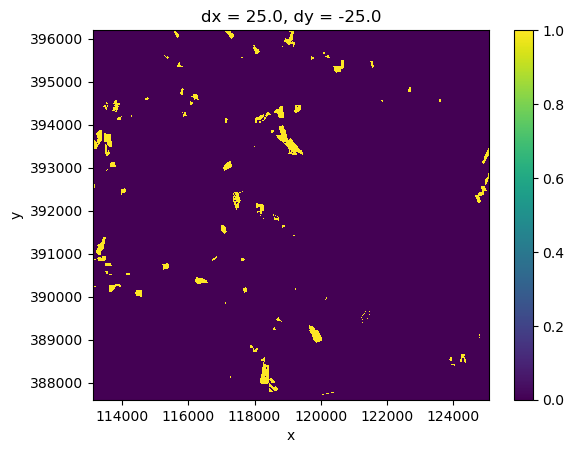

In [17]:
i = 1
d_Diff[f'Sys{i}'][2].plot()

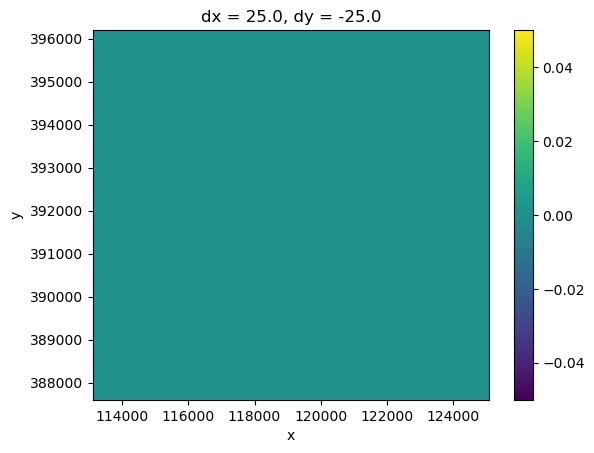

In [18]:
d_Diff[f'Sys{i}'][3].plot()

We'll work with the elevation array, as it has fewer values than the conductance array (assuming DRN is disabled everywhere where only one of them has a value.)

In [19]:
A_DRN_Atv = d_Diff[f'Sys{i}'][1]

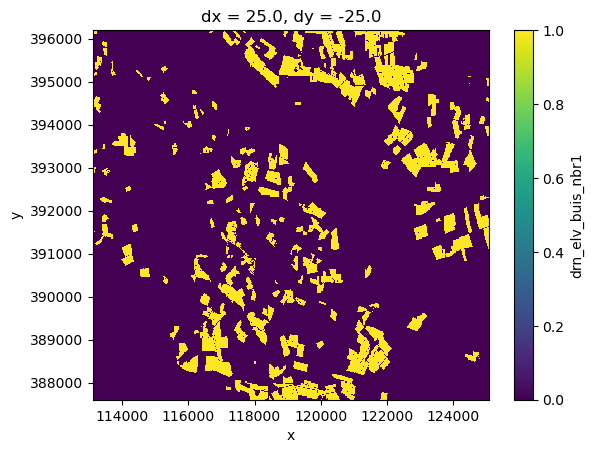

In [20]:
A_DRN_Atv.plot()

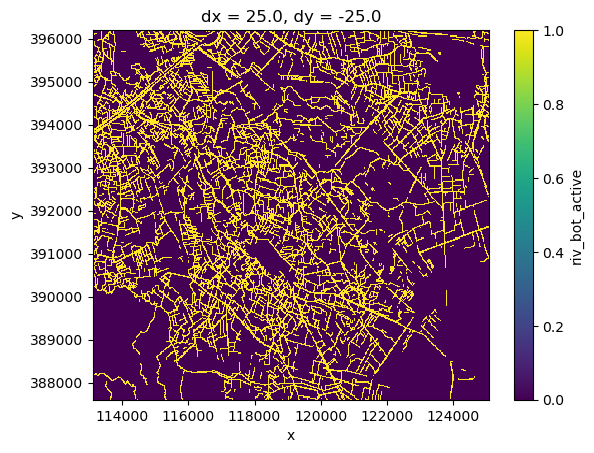

In [21]:
A_SFR_Atv.plot()

# 3. Connect DRN cells to SFR cells

In [22]:
DF = match_cells_to_SFR(A_SFR_Atv, A_DRN_Atv).drop('distance', axis=1)

We've connected them cell to cell, but we need to connect them based on the internal ids for each package.
- For DRN the id is the number of the element, as it's written in the PERIOD block (i.e. its line number)
- For SFR it's the reach number.

# 4. Convert cellids to package ids

## 4.0. Load DRN and SFR PACKAGEDATA

In [23]:
DF_DRN_ = pd.read_csv(
    Pa_DRN,
    delim_whitespace=True,  # splits on one-or-more spaces/tabs
    names=['L', 'R', 'C', 'elevation', 'conductance', 'aux'],
    header=None,
    engine='python',  # needed for skipfooter
    skipfooter=12,
)
DF_DRN_ = DF_DRN_.drop(
    columns=[i for i in DF_DRN_.columns if i not in ['L', 'R', 'C']]
)  # We only need L, R, C for matching.
DF_DRN_.index += 1  # Make it 1-based index, as in MODFLOW.

In [24]:
DF_DRN_ = DF_DRN_.reset_index().rename(columns={'index': 'Pvd_i'})

In [25]:
DF_SFR = U.MF6_block_to_DF(Pa_SFR, 'PACKAGEDATA', has_header=False, skipfooter=1)
DF_SFR = DF_SFR.drop(
    columns=[i for i in DF_SFR.columns if i not in ['ifno', 'L', 'R', 'C']]
)  # We only need L, R, C for matching.
DF_SFR = DF_SFR.rename(columns={'ifno': 'Rcv_i'})

C:\Users\Karam014\OneDrive - Universiteit Utrecht\WS_Mdl\code\WS_Mdl\utils.py:329: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  DF = pd.read_csv(


In [26]:
DF_DRN_.head()

,Pvd_i,L,R,C
0,1,1,2,2
1,2,1,2,3
2,3,1,2,4
3,4,1,2,5
4,5,1,2,143


In [27]:
DF_SFR.head()

,Rcv_i,L,R,C
0,1,1,1,6
1,2,1,1,11
2,3,1,1,12
3,4,1,1,18
4,5,1,1,20


## 4.1. Trim array edges and start merging.

In [28]:
DF = DF.loc[
    (DF['Tgt_R'] != 1) & (DF['Tgt_C'] != 1) & (DF['Tgt_R'] != N_R) & (DF['Tgt_C'] != N_C)
]  # items at the edges of the models aren't connected to DRN (that's default iMOD behaviour, I think)

In [29]:
DF1 = DF.merge(
    DF_DRN_, left_on=[f'Tgt_{i}' for i in ('L', 'R', 'C')], right_on=['L', 'R', 'C'], how='left'
)
DF1 = DF1.drop(
    columns=['Tgt_L', 'Tgt_R', 'Tgt_C', 'L', 'R', 'C']
)  # Those are redundant now. We only need SFR L R C to connect to reach numbers.

In [30]:
DF1.head()

,SFR_L,SFR_R,SFR_C,Pvd_i
0,1,4,3,1
1,1,4,3,22491
2,1,4,3,2
3,1,4,3,22492
4,1,2,6,3


In [31]:
DF2 = DF1.merge(
    DF_SFR, left_on=[f'SFR_{i}' for i in ('L', 'R', 'C')], right_on=['L', 'R', 'C'], how='left'
)  # likewise for the other DF
DF2 = DF2.drop(columns=['SFR_L', 'SFR_R', 'SFR_C', 'L', 'R', 'C'])  # Those are redundant now.

In [32]:
t = U.DF_to_MF_block(DF2)

In [33]:
l = []

In [34]:
l.append(t)

In [35]:
l[0]

'    #Pvd_i Rcv_i\n         1   394\n     22491   394\n         2   394\n     22492   394\n         3   136\n     22493   136\n         4   136\n     22494   136\n         5   173\n     22632   173\n         6    53\n     22633    53\n         7   298\n     22634   298\n         8   174\n     22635   174\n         9   183\n     22649   183\n        10   446\n     22660   446\n        11    66\n     22661    66\n        12    66\n     22662    66\n        13   187\n     22663   187\n        14   449\n     22672   449\n        15   449\n     22673   449\n        16   311\n     22674   311\n        17   204\n     22722   204\n        18   204\n     22723   204\n        19   331\n     22724   331\n        20   205\n     22725   205\n        21   207\n     22734   207\n        22   207\n     22735   207\n        23   207\n     22736   207\n        24   335\n     22737   335\n        25   208\n     22738   208\n        26   211\n     22747   211\n        27   211\n     22748   211\n        2

# 4. Write MVR file 

In [37]:
Pa_MVR = PJ(d_Pa['Pa_Mdl'], f'In/MVR/{MdlN}/{MdlN}.MVR')

In [45]:
w_MVR(DF2, filename=Pa_MVR)

Path('C:/OD/WS_Mdl/models/NBr/In/MVR/NBr29/NBr29.MVR')

# -1. Junkyard

#### Explore DRN_SFR_Match.

tree, SFR_i = DRN_SFR_match._build_SFR_tree(A_SFR_Atv)

target_mask = (A_DRN_Atv.astype(bool) if A_DRN_Atv is not None else xr.ones_like(A_SFR_Atv, dtype=bool))

targ_idx = DRN_SFR_match._as_index_array(target_mask)

dist, nearest_pos = tree.query(targ_idx, k=1)
nearest_i = SFR_i[nearest_pos]

from math import sqrt
sqrt(16**2 + 15**2)

nearest_pos

nearest_i

nearest_pos

SFR_i.shape[]

type(dist)

pd.Series(dist, name='a').describe()

DF = pd.DataFrame({"Tgt_L": targ_idx[:, 0],
                    "Tgt_R": targ_idx[:, 1],
                    "Tgt_C": targ_idx[:, 2],
                    "SFR_L": nearest_i[:, 0],
                    "SFR_R": nearest_i[:, 1],
                    "SFR_C": nearest_i[:, 2],
                    "distance": dist,})

DF[DF.columns.drop('distance')] = DF[DF.columns.drop('distance')] + 1 # Add 1 to all indices to convert from 0-based to 1-based indexing.

DF['distance'] = DF['distance'].round(2)

#### Investigation of inconsistencies between Sys1 & 3 active arrays

i = 1
d_Diff[list(d_Diff.keys())[i]][0].plot()
d_Diff[list(d_Diff.keys())[i]][1].plot()

d_Diff

A3 = xr.where( (A1==1) & (A2==0), 1, 0)
A4 = xr.where( (A1==0) & (A2==1), 1, 0)                
A3.plot()

A4.plot()

#### Initial attempt to connect

os.listdir(Pa_TOP)
Fi_TOP_L1 = [i for i in os.listdir(Pa_TOP) if ('_L1_' in i) and ('.dvc' not in i)]
TOP = imod.formats.idf.open(PJ(Pa_TOP, Fi_TOP_L1[0]), pattern="{name}_L{layer}_").sel(x=slice(Xmin, Xmax), y=slice(Ymax, Ymin))
PJ(Pa_TOP, Fi_TOP_L1[0])
TOP.plot()

OFFSETS = [(-1,  0),  # 0: N
           (-1,  1),  # 1: NE
           ( 0,  1),  # 2: E
           ( 1,  1),  # 3: SE
           ( 1,  0),  # 4: S
           ( 1, -1),  # 5: SW
           ( 0, -1),  # 6: W
           (-1, -1)]  # 7: NW

def flow_direction_xr(elev_da: xr.DataArray) -> xr.DataArray:
    """
    Compute D8 flow-direction grid for a 2-D xarray DataArray
    (dims: 'y', 'x').  Returns a new DataArray with int16 codes.

    Codes: 0-7 clockwise from North; -1 = sink / flat / edge.
    """
    if list(elev_da.dims) != ['y', 'x']:
        raise ValueError("Input DataArray must have dims ('y','x').")

    # Stack the 8 drops into a new 'direction' dimension
    drops = []
    for di, dj in OFFSETS:
        # shift puts neighbour into candidate cell; NaNs created at edges
        shifted = elev_da.shift(y=-di, x=-dj)
        drop = elev_da - shifted
        drop = drop.where(~np.isnan(shifted), -np.inf)   # no descent beyond edge
        drops.append(drop)

    drop_stack = xr.concat(drops, dim='direction')       # shape: (direction, y, x)

    # Best direction & maximum drop
    best_dir = drop_stack.argmax(dim='direction')        # int indices 0-7
    max_drop = drop_stack.max(dim='direction')

    # Mark cells with no downhill neighbour (max_drop ≤ 0) as -1
    flow_dir = best_dir.where(max_drop > 0, -1).astype(np.int16)

    # Nice metadata
    flow_dir.name = 'flow_dir'
    flow_dir.attrs.update(
        description="D8 flow direction (0=N … 7=NW, -1=sink/flat/edge)",
        nodata=-1
    )
    return flow_dir

A = flow_direction_xr(TOP)